<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE/blob/main/notebooks/sdo_bin_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification of full-disk SDO/AIA Data

> This notebook is part of the Master Thesis *Predicting Coronal Mass Ejections using Machine Learning methods* by Wilmar Ender, FH Wiener Neustadt.

This notebook aims to apply a simple binary image classifier on the SDO/AIA dataset.

**Solar event list:** \\
*Liu et al. 2020, Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks*

**Dataset:** \\
*Ahmadzadeh et al. 2019, A Curated Image Parameter Data Set from the Solar Dynamics Observatory Mission*. \\
Accessed via *sdo-cli* (https://github.com/i4Ds/sdo-cli)

**Model Architecture:** \\
TBD

## Set up Notebook

In [ ]:
%%capture
pip install -U sdo-cli

In [ ]:
from pathlib import Path
import os
import requests
import subprocess
import shutil
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from keras.layers import Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Input, GlobalAveragePooling2D

In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change present working directory
%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/sdo_binclass

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/sdo_binclass


In [ ]:
!ls -a

cme_classifier.h5  model_plot.png  Models		       .sdo-cli
data		   models	   path_to_your_output_folder


## Helper Functions

In [ ]:
def create_sdo_aia_dataset(output_dir, start_idx, event_list, dt, wavelength ):
  '''
  download with the help of sdo-cli AIA images
  input:
  file_path = as a string where the images should be saved
  eventlist = dataframe which provides CME data like start, peak and end time
  dt = string, time step between images (if possible), e.g. '6min'
  wavelength = string, corresponing wavelegth channel of AIA e.g. '171' for 171 Angström channel

  output:
  images (51x512) within folder
  '''

  for idx in range(start_idx, event_list.shape[0]):
    start_time = event_list['Timestamp'][idx]
    end_time =   event_list['Timestamp'][idx]

    command = f"sdo-cli data download --path={output_dir} --start={start_time} --end={end_time} --freq={dt} --wavelength={wavelength}"
    subprocess.call(command, shell=True)
    print("\r", idx, ': downloading CME from ', start_time, end="")

In [ ]:
def compare_filenames_with_dataframe(directory, dataframe, wavelength):
    file_end = '_' + str(wavelength) + '.jpeg'
    # Get list of filenames from the directory
    directory_filenames = [filename for filename in os.listdir(directory) if filename.endswith(file_end)]

    # Get list of names from the DataFrame
    df_check = dataframe.copy()
    df_check['Timestamp'] = pd.to_datetime(df_check['Timestamp']).dt.strftime('%Y-%m-%dT%H%M%S__171.jpeg') # Warning! wavelength is now hard coded

    dataframe_names = df_check['Timestamp'].tolist()  # the name of the image should correspond to the timestamp

    # Compare filenames
    common_filenames = set(directory_filenames) & set(dataframe_names)
    missing_filenames = set(dataframe_names) - set(directory_filenames)
    extra_filenames = set(directory_filenames) - set(dataframe_names)

    df_missing = pd.DataFrame (data = missing_filenames,  columns=['Timestamp'])
    df_missing['Timestamp'] = df_missing['Timestamp'].str.replace(r'__171.jpeg', '', regex=True)
    df_missing['Timestamp'] = pd.to_datetime(df_missing['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')

    # Calculate statistics
    total_directory_files = len(directory_filenames)
    total_dataframe_names = len(dataframe_names)
    total_common_files = len(common_filenames)
    total_missing_files = len(missing_filenames)
    total_extra_files = len(extra_filenames)
    print('Total Directory Files: ', total_directory_files)
    print('Total DataFrame Names: ', total_dataframe_names)
    print('Common Files: ', total_common_files)
    print('Missing Files: ', total_missing_files)
    print('Extra Files: ', total_extra_files)

    statistics = {
        'Total Directory Files': total_directory_files,
        'Total DataFrame Names': total_dataframe_names,
        'Common Files': total_common_files,
        'Missing Files': total_missing_files,
        'Extra Files': total_extra_files,
        #'Common File Names': common_filenames,
        'Missing File Names': missing_filenames,
        'Extra File Names': extra_filenames
    }

    return statistics, df_missing

## Get Solar Events


### Event-List 1: events-only
Event Catalog from: \\
*Liu et al. 2020, Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks*

The following two lists are only the events itself! (used for a first evaluation when working with small dataset)

In [ ]:
# load list with both (neg, pos) labels
df_cme_list = pd.read_csv(r'data/event_lists/all_cme_events.csv', delimiter =';')

In [ ]:
# list with only cme events
df_cme_list = pd.read_csv(r'data/event_lists/cme_events.csv', delimiter =';')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44Z,2011-02-15T01:56Z,2011-02-15T02:06Z,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23Z,2011-02-24T07:35Z,2011-02-24T07:42Z,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43Z,2011-03-07T20:12Z,2011-03-07T20:58Z,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45Z,2011-03-07T14:30Z,2011-03-07T14:56Z,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37Z,2011-03-08T03:58Z,2011-03-08T04:20Z,11171,415,2011-03-08T05:00:00-CME-001


There are (only) 129 CME events in the list. \\
**Note:** these CMEs are considered as "positive" because they are associated with a Solar Flare! see paper for details!
> This yields a database of 129 M- and X-class flares that are associated with CMEs and 610 M- and X-class flares that are not associated with CMEs.

In [ ]:
# convert time stamp such that sdo-cli can read them
df_cme_list['Start Time'] = pd.to_datetime(df_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['Peak Time'] = pd.to_datetime(df_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['End Time'] = pd.to_datetime(df_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44:00,2011-02-15T01:56:00,2011-02-15T02:06:00,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23:00,2011-02-24T07:35:00,2011-02-24T07:42:00,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43:00,2011-03-07T20:12:00,2011-03-07T20:58:00,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45:00,2011-03-07T14:30:00,2011-03-07T14:56:00,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37:00,2011-03-08T03:58:00,2011-03-08T04:20:00,11171,415,2011-03-08T05:00:00-CME-001


In [ ]:
# do the same for the negative labeled list
df_no_cme_list = pd.read_csv(r'data/event_lists/no_cme_events.csv', delimiter =';')
df_no_cme_list['Start Time'] = pd.to_datetime(df_no_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['Peak Time'] = pd.to_datetime(df_no_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['End Time'] = pd.to_datetime(df_no_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list.tail()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
605,M1.3,2017-09-08T02:19:00,2017-09-08T02:24:00,2017-09-08T02:29:00,12673,7115,No
606,M1.2,2017-09-04T05:36:00,2017-09-04T05:49:00,2017-09-04T06:05:00,12673,7115,No
607,M1.1,2017-09-09T04:14:00,2017-09-09T04:28:00,2017-09-09T04:43:00,12673,7115,No
608,M1.1,2017-09-09T22:04:00,2017-09-09T23:53:00,2017-09-10T00:41:00,12673,7115,No
609,M1.0,2017-09-05T03:42:00,2017-09-05T03:51:00,2017-09-05T04:04:00,12673,7115,No


As one can see, there are 610 negative labeled events

### Event-List 2: sampled events
Same list from *Liu et al. 2020*, however the events were sampled for predicting CMEs within the next x hours (x = 12, 24, 36, 48 or 60).

> N means there is a >=M class flare within the next x hours but this flare is not associated with a CME. \\
> P means there is a >=M class flare within the next x hours and this flare is associated with a CME. \\
> The second column is titled Timestamp. \\
> The third column and fourth column are titled NOAA active region number and HARP number, respectively. \\
> Starting from the fifth column, you can see physical parameters of data samples, which include 18 SHARP parameters:
TOTUSJH, TOTPOT, TOTUSJZ, ABSNJZH, SAVNCPP, USFLUX, AREA_ACR, MEANPOT, R_VALUE, SHRGT45, MEANGAM, MEANJZH, MEANGBT, MEANGBZ, MEANJZD, MEANGBH, MEANSHR, MEANALP.

#### Test Data

In [ ]:
# load list with both (neg, pos) labels of testing list for t= 12 h
df_cme_test_12 = pd.read_csv(r'data/Liu2020_CME_data_samples/normalized_testing_12.csv', delimiter =',')
df_cme_test_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2016-02-11T22:58:09.90Z,12497,6327,0.3925,-0.2331,0.4536,0.9205,1.0290,-0.0909,...,0.3442,-0.0754,0.3384,-1.6783,1.2374,1.1869,0.5194,0.6876,0.1579,-0.7577
1,N,2016-02-11T23:10:09.90Z,12497,6327,0.4030,-0.2328,0.4527,0.9448,0.9703,-0.0821,...,0.3969,-0.1284,0.3151,-1.6798,1.2349,1.1826,1.1634,0.6851,0.1416,-0.7672
2,N,2016-02-11T23:22:09.90Z,12497,6327,0.4127,-0.2295,0.4665,1.0729,1.1235,-0.0793,...,0.4348,-0.1012,0.3018,-1.8024,1.2517,1.1898,1.1432,0.6877,0.1457,-0.8262
3,N,2016-02-11T23:34:10.00Z,12497,6327,0.4183,-0.2292,0.4679,1.0541,1.0207,-0.0777,...,0.4516,-0.1595,0.2761,-1.7795,1.2329,1.1921,1.2066,0.6774,0.1143,-0.8189
4,N,2016-02-11T23:46:10.00Z,12497,6327,0.3991,-0.2277,0.4601,1.1108,1.0915,-0.0865,...,0.4488,-0.1515,0.2837,-1.8467,1.2195,1.1594,1.0569,0.6803,0.1153,-0.8529


In [ ]:
df_cme_test_12.shape

(1312, 22)

In [ ]:
# reduce dataframe to relevant columns
df_cme_test_12 = df_cme_test_12.drop(['TOTUSJH',	'TOTPOT',	'TOTUSJZ',	'ABSNJZH',	'SAVNCPP',
                     'USFLUX', 'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45',
                     'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ', 'MEANJZD',
                     'MEANGBH', 'MEANSHR', 'MEANALP'], axis=1)
df_cme_test_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
0,N,2016-02-11T22:58:09.90Z,12497,6327
1,N,2016-02-11T23:10:09.90Z,12497,6327
2,N,2016-02-11T23:22:09.90Z,12497,6327
3,N,2016-02-11T23:34:10.00Z,12497,6327
4,N,2016-02-11T23:46:10.00Z,12497,6327


In [ ]:
df_cme_test_12.shape

(1312, 4)

In [ ]:
# convert time stamp
# convert time stamp such that sdo-cli can read them
df_cme_test_12['Timestamp'] = pd.to_datetime(df_cme_test_12['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_test_12.tail()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
1307,N,2017-09-08T21:46:41,12673,7115
1308,N,2017-09-08T21:58:41,12673,7115
1309,N,2017-09-08T22:10:41,12673,7115
1310,N,2017-09-08T22:22:41,12673,7115
1311,N,2017-09-08T22:34:41,12673,7115


In [ ]:
df_cme_test_12_neg = df_cme_test_12.loc[df_cme_test_12['Label'] == 'N']
df_cme_test_12_neg = df_cme_test_12_neg.reset_index(drop=True)
print('There are', df_cme_test_12_neg.shape[0], 'negative samples in the test set.\n')
df_cme_test_12_neg.tail()

There are 762 negative samples in the test set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
757,N,2017-09-08T21:46:41,12673,7115
758,N,2017-09-08T21:58:41,12673,7115
759,N,2017-09-08T22:10:41,12673,7115
760,N,2017-09-08T22:22:41,12673,7115
761,N,2017-09-08T22:34:41,12673,7115


In [ ]:
df_cme_test_12_pos = df_cme_test_12.loc[df_cme_test_12['Label'] == 'P']
df_cme_test_12_pos = df_cme_test_12_pos.reset_index(drop=True)
print('There are', df_cme_test_12_pos.shape[0], 'positive samples in the test set.\n')
df_cme_test_12_pos.tail()

There are 550 positive samples in the test set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
545,P,2017-09-08T05:10:41,12673,7115
546,P,2017-09-08T05:22:41,12673,7115
547,P,2017-09-08T05:34:41,12673,7115
548,P,2017-09-08T05:46:41,12673,7115
549,P,2017-09-08T06:10:41,12673,7115


#### Training Data:
Do the same steps for the training set:

In [ ]:
# load list with both (neg, pos) labels of testing list for t= 12 h
df_cme_training_12 = pd.read_csv(r'data/Liu2020_CME_data_samples/normalized_training_12.csv', delimiter =',')
df_cme_training_12.shape
df_cme_training_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2010-05-05T05:22:22.90Z,11069,8,-0.5461,-0.5672,-0.6696,0.3159,0.2083,-0.7610,...,0.3751,-0.4109,-0.1049,-3.3554,0.5327,0.6921,-0.1673,0.5768,-0.1024,-1.1464
1,N,2010-05-05T05:34:22.90Z,11069,8,-0.5438,-0.5635,-0.6607,0.3360,0.2741,-0.7552,...,0.3969,-0.3188,-0.0283,-3.2984,0.4808,0.6302,-0.0497,0.5683,-0.0324,-1.1596
2,N,2010-05-05T05:46:22.90Z,11069,8,-0.5469,-0.5604,-0.6521,0.3315,0.3650,-0.7518,...,0.3961,-0.2149,0.0489,-3.1799,0.4268,0.5787,-0.1523,0.5588,0.0503,-1.1509
3,N,2010-05-05T06:22:22.90Z,11069,8,-0.5275,-0.5546,-0.6356,0.3042,0.2075,-0.7346,...,0.3842,-0.2724,0.0144,-2.9791,0.4130,0.5345,-0.0549,0.5549,0.0166,-1.0816
4,N,2010-05-05T06:34:22.90Z,11069,8,-0.5212,-0.5481,-0.6294,0.3653,0.2579,-0.7322,...,0.3554,-0.2530,0.0585,-3.1240,0.4596,0.6073,0.1217,0.5626,0.0660,-1.1460


In [ ]:
# reduce dataframe to relevant columns
df_cme_training_12 = df_cme_training_12.drop(['TOTUSJH',	'TOTPOT',	'TOTUSJZ',	'ABSNJZH',	'SAVNCPP',
                     'USFLUX', 'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45',
                     'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ', 'MEANJZD',
                     'MEANGBH', 'MEANSHR', 'MEANALP'], axis=1)


In [ ]:
df_cme_training_12['Timestamp'] = pd.to_datetime(df_cme_training_12['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_training_12.tail()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
20342,N,2016-01-01T21:22:08,12473,6206
20343,N,2016-01-01T21:34:08,12473,6206
20344,N,2016-01-01T21:46:08,12473,6206
20345,N,2016-01-01T21:58:08,12473,6206
20346,N,2016-01-01T22:22:08,12473,6206


Since the currated dataset from Ahmadzadeh et al. 2019, starts at January 2011, we have to drop the rows until this date:

In [ ]:
df_cme_training_12 = df_cme_training_12.tail(df_cme_training_12.shape[0] -282)
df_cme_training_12

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
282,N,2011-02-08T13:46:11,11153,362
283,N,2011-02-08T13:58:11,11153,362
284,N,2011-02-08T14:10:11,11153,362
285,N,2011-02-08T14:22:11,11153,362
286,N,2011-02-08T14:34:11,11153,362
...,...,...,...,...
20342,N,2016-01-01T21:22:08,12473,6206
20343,N,2016-01-01T21:34:08,12473,6206
20344,N,2016-01-01T21:46:08,12473,6206
20345,N,2016-01-01T21:58:08,12473,6206


In [ ]:
df_cme_training_12 = df_cme_training_12.reset_index(drop=True)
df_cme_training_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
0,N,2011-02-08T13:46:11,11153,362
1,N,2011-02-08T13:58:11,11153,362
2,N,2011-02-08T14:10:11,11153,362
3,N,2011-02-08T14:22:11,11153,362
4,N,2011-02-08T14:34:11,11153,362


In [ ]:
df_cme_training_12.shape

(20065, 4)

In [ ]:
# get negative samples
df_cme_training_12_neg = df_cme_training_12.loc[df_cme_training_12['Label'] == 'N']
df_cme_training_12_neg = df_cme_training_12_neg.reset_index(drop=True)
print('There are', df_cme_training_12_neg.shape[0], 'negative samples in the training set.\n')
df_cme_training_12_neg.tail()

There are 16678 negative samples in the training set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
16673,N,2016-01-01T21:22:08,12473,6206
16674,N,2016-01-01T21:34:08,12473,6206
16675,N,2016-01-01T21:46:08,12473,6206
16676,N,2016-01-01T21:58:08,12473,6206
16677,N,2016-01-01T22:22:08,12473,6206


In [ ]:
# get positive samples
df_cme_training_12_pos = df_cme_training_12.loc[df_cme_training_12['Label'] == 'P']
df_cme_training_12_pos = df_cme_training_12_pos.reset_index(drop = True)
print('There are', df_cme_training_12_pos.shape[0], 'positive samples in the training set.\n')
df_cme_training_12_pos.tail()

There are 3387 positive samples in the training set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
3382,P,2015-12-28T11:46:08,12473,6206
3383,P,2015-12-28T11:58:08,12473,6206
3384,P,2015-12-28T12:10:08,12473,6206
3385,P,2015-12-28T12:22:08,12473,6206
3386,P,2015-12-28T12:34:08,12473,6206


By now we have four event lists from the sampled dataset:


*   df_cme_test_12_neg >> 762
*   df_cme_test_12_pos >> 550
*   df_cme_training_12_neg >> 16678
*   df_cme_training_12_pos >> 3387 samples



## Download and Check Images

### From Event-List 1: events-only

In [ ]:
# create_sdo_aia_dataset(file_path = './data/raw/raw_512/positive/', event_list = df_cme_list, dt = '60min', wavelength = '171')

In [ ]:
# create_sdo_aia_dataset(file_path = './data/raw/raw_512/negative/', event_list = df_no_cme_list, dt = '60min', wavelength = '171')

now that the images were downloaded, we check the smaples against the list if there are many corrupted samples

### From Event-List 2: sampled events

#### Testing - negative

In [ ]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/neg/', start_idx=0, event_list = df_cme_test_12_neg, dt = '10min', wavelength = '171')

Check the directory/folder if the downloaded imaged correspond to the timestamps of the event list.

In [ ]:
directory_path_test_12_neg = './data/Liu2020_sampled/test_12/neg/'
result_test_12_neg, missing_files_test_neg = compare_filenames_with_dataframe(directory_path_test_12_neg, df_cme_test_12_neg, 171)


Total Directory Files:  739
Total DataFrame Names:  762
Common Files:  739
Missing Files:  23
Extra Files:  0


In [ ]:
missing_files_test_neg.tail()

,Timestamp
18,2017-07-08T19:10:46
19,2017-09-05T21:10:41
20,2017-07-08T18:34:46
21,2017-07-08T17:34:46
22,2017-07-08T20:46:46


Download missing samples

In [ ]:
# Tests
!sdo-cli data download --path='./data/Liu2020_sampled/Missing-Test-neg' --start='2017-07-09T20:46:00' --end='2017-07-08T21:00:00' --freq='15min' --wavelength='171'

2023-08-11 07:02:07,805 numexpr.utils    INFO NumExpr defaulting to 8 threads.
2023-08-11 07:02:10,125 sdo.cli          INFO Starting to download images...
2023-08-11 07:02:10,128 sdo.cli          INFO loading data for 0 images between 2017-07-09 20:46:00 and 2017-07-08 21:00:00 for wavelengths ('171',)
0it [00:00, ?it/s]


In [ ]:
create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/Missing-Test-neg', start_idx=0, event_list = missing_files_test_neg, dt = '15min', wavelength = '171')

 22 : downloading CME from  2017-07-08T20:46:46

Check again:

In [ ]:
result_test_12_neg, missing_files_test_neg = compare_filenames_with_dataframe(directory_path_test_12_neg, df_cme_test_12_neg, 171)

Total Directory Files:  739
Total DataFrame Names:  762
Common Files:  739
Missing Files:  23
Extra Files:  0


#### Testing - positive

In [ ]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/pos/', start_idx= 0, event_list = df_cme_test_12_pos, dt = '10min', wavelength = '171')

In [ ]:
directory_path_test_12_pos = './data/Liu2020_sampled/test_12/pos/'
result_test_12_neg, missing_test_pos = compare_filenames_with_dataframe(directory_path_test_12_pos, df_cme_test_12_pos, 171)


Total Directory Files:  549
Total DataFrame Names:  550
Common Files:  549
Missing Files:  1
Extra Files:  0


In [ ]:
missing_test_pos

,Timestamp
0,2017-09-07T22:58:41


In [ ]:
create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/pos/', start_idx=0, event_list = missing_test_pos, dt = '10min', wavelength = '171')

 0 : downloading CME from  2017-09-07T22:58:41

In [ ]:
result_test_12_neg, missing_test_pos = compare_filenames_with_dataframe(directory_path_test_12_pos, df_cme_test_12_pos, 171)

Total Directory Files:  549
Total DataFrame Names:  550
Common Files:  549
Missing Files:  1
Extra Files:  0


#### Training - negative

In [ ]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/training_12/neg/', start_idx=0,  event_list = df_cme_training_12_neg, dt = '10min', wavelength = '171')

In [ ]:
directory_path_training_12_neg = './data/Liu2020_sampled/training_12/neg/'
result_test_12_neg, missing_files_training_neg = compare_filenames_with_dataframe(directory_path_training_12_neg, df_cme_training_12_neg,171)

Total Directory Files:  2971
Total DataFrame Names:  16678
Common Files:  2971
Missing Files:  12886
Extra Files:  0


Download the missing files for the negative trainig samples

In [ ]:
#create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/Missing-Training-neg', start_idx=0, event_list = missing_files_training_neg, dt = '10min', wavelength = '171')

In [ ]:
directory_path_training_12_neg = './data/Liu2020_sampled/Missing-Training-neg'
result_test_12_neg, missing_files_training_neg = compare_filenames_with_dataframe(directory_path_training_12_neg, missing_files_training_neg, 171)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-2b94e50dc0a7>", line 2, in <cell line: 2>
    result_test_12_neg, missing_files_training_neg = compare_filenames_with_dataframe(directory_path_training_12_neg, df_cme_training_12_neg, 171)
  File "<ipython-input-7-247984e1c52a>", line 4, in compare_filenames_with_dataframe
    directory_filenames = [filename for filename in os.listdir(directory) if filename.endswith(file_end)]
OSError: [Errno 107] Transport endpoint is not connected: './data/Liu2020_sampled/training_12/neg/'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attrib

#### Training - positive

In [ ]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/training_12/pos/', start_idx=0, event_list = df_cme_training_12_pos, dt = '10min', wavelength = '171')

In [ ]:
directory_path_training_12_pos = './data/Liu2020_sampled/training_12/pos/'
result_training_12_pos, missing_files_training_pos = compare_filenames_with_dataframe(directory_path_training_12_pos, df_cme_training_12_pos, 171)

Total Directory Files:  2540
Total DataFrame Names:  3387
Common Files:  2540
Missing Files:  717
Extra Files:  0


download missing files

In [ ]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/training_12/missing-pos/', start_idx=0, event_list = df_cme_training_12_pos, dt = '10min', wavelength = '171')

## Create Dataset

Positive Class: create positive class, i.e. CMEs which are related to Flares

Negative Class: create positive class, i.e. CMEs which are NOT related to Flares

#### Resize the Images


In [ ]:
#!sdo-cli data resize --path='./data/raw/raw_512/positive/' --targetpath='./data/raw/raw_256/positive' --wavelength='171' --size=256

In [ ]:
#!sdo-cli data resize --path='./data/raw/raw_512/negative/' --targetpath='./data/raw/raw_256/negative' --wavelength='171' --size=256

## Keras tutorial

In [ ]:
#%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/sdo_binclass/data/raw/

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/sdo_binclass/data/raw


In [ ]:
#!ls raw_512

negative  positive


In [ ]:
num_skipped = 0
for folder_name in ("negative", "positive"):
    folder_path = os.path.join("raw_512", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 50

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "raw_512",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 799 files belonging to 2 classes.
Using 640 files for training.
Using 159 files for validation.


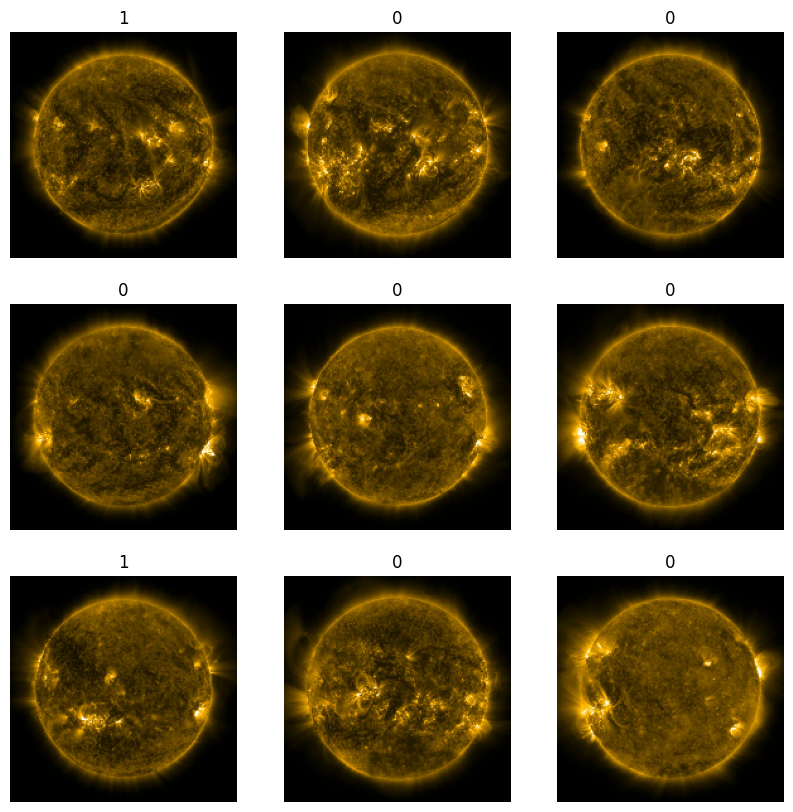

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

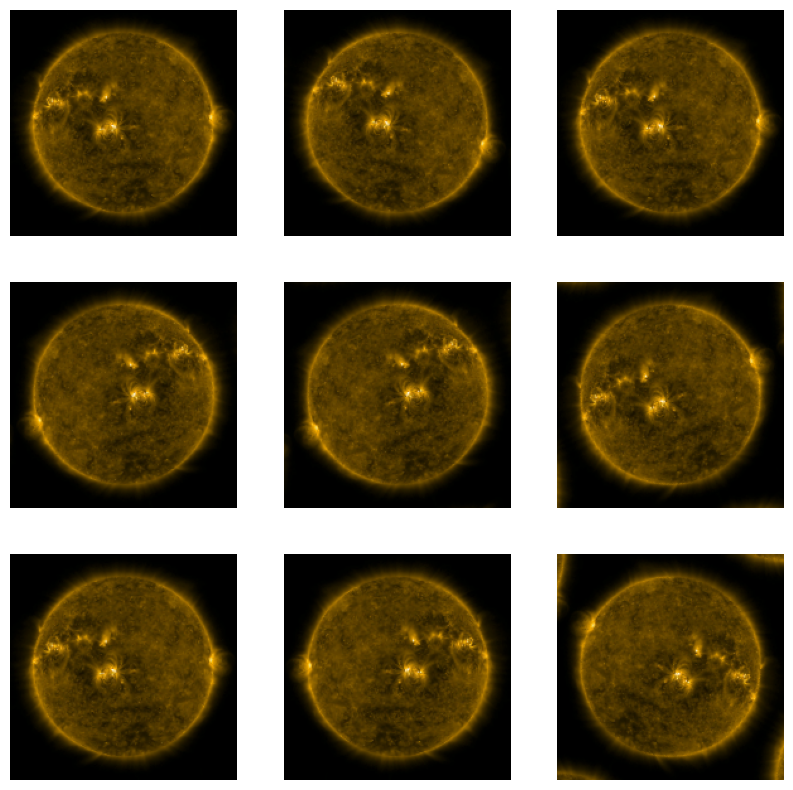

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def make_model(input_shape, num_classes, hp):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

TypeError: ignored

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

## ConvNet binary classifier

### Split Image-Data - OLD shit!
The following function splits the downloaded data into three dataset, namely:


*   training
*   test
*   validation

with corresponding negative and positive samples.


In [ ]:
def split_dataset(input_dir, output_dir, test_ratio, val_ratio, random_seed=None):
  '''
  - Replace 'input_dir' with the path to your 'dataset' folder and 'output_dir' with the desired output path.
  - The function will create 'train', 'test', and 'validation' folders inside the 'output_dir' and split the data accordingly.
  - Don't forget to specify the 'test_ratio', 'val_ratio', and 'random_seed' if desired.
  '''

  if random_seed is not None:
      random.seed(random_seed)

  # Create output directories for train, test, and validation
  train_dir = os.path.join(output_dir, 'train')
  test_dir = os.path.join(output_dir, 'test')
  val_dir = os.path.join(output_dir, 'validation')

  os.makedirs(train_dir, exist_ok=True)
  os.makedirs(test_dir, exist_ok=True)
  os.makedirs(val_dir, exist_ok=True)

  # Get the list of class folders in the input directory
  class_folders = os.listdir(input_dir)

  for class_folder in class_folders:
      # Get the path to the class folder
      class_path = os.path.join(input_dir, class_folder)

      # Get the list of image filenames in the class folder
      image_filenames = os.listdir(class_path)

      # Shuffle the image filenames randomly
      random.shuffle(image_filenames)

      # Calculate the number of images for testing and validation
      print('For the ', class_folder, 'class:')
      num_images = len(image_filenames)
      print('There are in total', num_images, ' images.')

      num_test_images = int(num_images * test_ratio)
      print('With ', num_test_images, 'images for testing, and')

      num_val_images = int(num_images * val_ratio)
      print(num_val_images, 'images for validation.\n')
      print('===================================\n')

      # Split the image filenames into train, test, and validation sets
      train_images = image_filenames[num_test_images + num_val_images:]
      test_images = image_filenames[:num_test_images]
      val_images = image_filenames[num_test_images:num_test_images + num_val_images]

      # Copy images to the corresponding directories
      for image_filename in train_images:
          src = os.path.join(class_path, image_filename)
          dst = os.path.join(train_dir, class_folder, image_filename)
          os.makedirs(os.path.dirname(dst), exist_ok=True)
          shutil.copy(src, dst)

      for image_filename in test_images:
          src = os.path.join(class_path, image_filename)
          dst = os.path.join(test_dir, class_folder, image_filename)
          os.makedirs(os.path.dirname(dst), exist_ok=True)
          shutil.copy(src, dst)

      for image_filename in val_images:
          src = os.path.join(class_path, image_filename)
          dst = os.path.join(val_dir, class_folder, image_filename)
          os.makedirs(os.path.dirname(dst), exist_ok=True)
          shutil.copy(src, dst)


In [ ]:
input_dir = './data/raw/raw_256/'
output_dir = './data/datasets/Test_1/'
test_ratio = 0.15
val_ratio = 0.15
random_seed = 42  # Optional, set to None for random shuffling each time.
split_dataset(input_dir, output_dir, test_ratio, val_ratio, random_seed)

### Define Parameter

In [ ]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
dataset_path = './data/datasets/Test_1/'
input_shape = (256, 256, 3)
num_classes = 2
batch_size = 32
epochs = 20
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'validation'),
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
# train_generator = train_datagen.flow_from_directory(
#     './data/datasets/Test_1/',
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='binary',
#     subset='training'
# )

# validation_generator = train_datagen.flow_from_directory(
#     './data/datasets/Test_1/',
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='binary',
#     subset='validation'
# )

### Model 1: Wang et al. 2019, CME-CNN
CME Arrival Time Prediction Using Convolutional Neural Network
Yimin Wang, Jiajia Liu, Ye Jiang, Robert Erdélyi
The Astrophysical Journal, 2019

See: https://github.com/yiminking/CME-CNN/blob/master/model_loader.py

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(11, 11), input_shape=(input_shape[0], input_shape[1],input_shape[2]), padding='same'))
model.add(BatchNormalization(momentum=0.7))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(128, kernel_size=(11, 11), padding='same'))
model.add(BatchNormalization(momentum=0.7))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(256, kernel_size=(11, 11), padding='same'))
model.add(BatchNormalization(momentum=0.7))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])
history = model.fit(train_generator, batch_size=batch_size, epochs=20, verbose=1)
# Save the trained model
model.save('./Models/cme_classifier_Model-1.h5')
model.summary()
tf.keras.utils.plot_model(model, to_file="./Models/Model-1_Wang.png", show_shapes=True)

### Model 2

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape[0], input_shape[1], input_shape[2])))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=epochs, validation_data=val_generator)

# Save the trained model
model.save('./models/cme_classifier_Model-2.h5')
model.summary()
#tf.keras.utils.plot_model(model, to_file="./data/datasets/Test_2/model-2.png", show_shapes=True)

### Model 3: Data Augmentation

In [ ]:
# Step 1: Split data into train, test, and validation sets
#def split_data(input_dir, output_dir, test_ratio, val_ratio):
    # Use the split_data_into_sets function here
    # ... (the function we previously defined)

# Replace 'dataset_path' with the path to your 'dataset' folder.
# The function will create 'train', 'test', and 'validation' folders inside the 'dataset' folder.
# It will then split the data from 'positive' and 'negative' folders into these sets.
#dataset_path = './data/datasets/Test_1/'
#split_data(dataset_path, dataset_path, test_ratio, val_ratio)

# Step 2: Data Augmentation
# train_data_gen =  (
#     rescale=1.0/255.0,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# test_data_gen = ImageDataGenerator(rescale=1.0/255.0)

# # Step 3: Create Data Generators for Train, Test, and Validation Sets
# train_generator = train_data_gen.flow_from_directory(
#     os.path.join(dataset_path, 'train'),
#     target_size=(input_shape[0], input_shape[1]),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_generator = test_data_gen.flow_from_directory(
#     os.path.join(dataset_path, 'test'),
#     target_size=(input_shape[0], input_shape[1]),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )

# val_generator = test_data_gen.flow_from_directory(
#     os.path.join(dataset_path, 'validation'),
#     target_size=(input_shape[0], input_shape[1]),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )

# Step 4: Build the CNN Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Step 5: Compile and Train the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Since the dataset is small, we'll use the fit() method directly instead of using fit_generator().
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Step 6: Evaluate the Model on the Test Set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", test_accuracy)

# Save the trained model
model.save('cme_classifier.h5')
model.plot()

## Evaluation

# Testground

In [ ]:
# testing the function on a portion of the dataset
df_cme_test_12_neg_part =  df_cme_test_12_neg.head(10)
df_cme_test_12_neg_part

In [ ]:
#create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/TEST2/', start_idx=5, event_list = df_cme_test_12_neg_part, dt = '10min', wavelength = '171')

In [ ]:
os.listdir('./data/Liu2020_sampled/TEST2/')

In [ ]:
dataframe_names = df_cme_test_12_neg_part['Timestamp'].tolist()
dataframe_names

In [ ]:
directory_TEST = './data/Liu2020_sampled/TEST2/'
result_TEST = compare_filenames_with_dataframe(directory_TEST, df_cme_test_12_neg_part,171)
result_TEST